In [1]:
from pathlib import Path
import gc

from transformers import AutoTokenizer
import torch
from torch import nn
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import f1_score
import pandas as pd
import numpy as np
from transformers import AutoConfig
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from model import Model
from train import Trainer
import mlflow

import dataset


# DEVICE = torch.device("cpu")
DEVICE = torch.device("cuda:0")

# pretrained_model_name = "DeepPavlov/distilrubert-tiny-cased-conversational-v1"
# pretrained_model_name = "cointegrated/rubert-tiny"
pretrained_model_name = "cointegrated/rubert-tiny2"
# pretrained_model_name = "DeepPavlov/rubert-base-cased"


In [2]:
allowed_labels = list(set(Path("./data_preparation/allowedLabels.txt").read_text().lower().split("\n")))

labels_encoder = preprocessing.LabelEncoder()
labels_encoder.fit(allowed_labels)

orig_tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name)

In [6]:
columns = pd.read_csv("./data/columns.csv", sep="<")["column"].astype(str).to_list()
tokenizer = orig_tokenizer.train_new_from_iterator([columns], 90000)

# tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name)

In [7]:
paths = pd.read_csv("./data/filteredData3/files_list.csv")["paths"].to_list()

train_paths, val_paths = train_test_split(paths, test_size=0.20,
                                          random_state=42)



# columns_dataloader = dataset.Columns("./data/columns.csv", tokenizer, labels_encoder).create_dataloader(batch_size=50, shuffle=True)


In [7]:
# experiment_name = "Optimizer settings"
# mlflow.create_experiment(name=experiment_name)

'808278770026265142'

In [5]:

# with mlflow.start_run(experiment_id="808278770026265142"):
with mlflow.start_run():
    gc.collect()
    torch.cuda.empty_cache()

    MAX_TOKENS_PER_COLUMN = 200  # 2 of those for CLS and SEP
    MAX_COLUMNS = 20
    MAX_TOKENS = 200  # per table

    mlflow.log_param("MAX_TOKENS_PER_COLUMN", MAX_TOKENS_PER_COLUMN)
    mlflow.log_param("MAX_COLUMNS", MAX_COLUMNS)
    mlflow.log_param("MAX_TOKENS", MAX_TOKENS)

    train_dataloader = dataset.Tables(train_paths, tokenizer, labels_encoder, use_rand=True).create_dataloader(
    batch_size=80,
    shuffle=True)
    val_dataloader = dataset.Tables(
        val_paths, tokenizer, labels_encoder).create_dataloader(batch_size=100)

    config = AutoConfig.from_pretrained(pretrained_model_name)
    config.update({"hidden_dropout_prob": 0.2,
                "layer_norm_eps": 1e-7})
    model = Model(config, labels_number=len(allowed_labels), pretrained_model_name=pretrained_model_name, tokenizer=tokenizer).to(DEVICE)

    lr = 1e-3
    weight_decay = 1e-4
    eps = 1e-8
    optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay, eps=eps)
    mlflow.log_param("lr", lr)
    mlflow.log_param("weight_decay", weight_decay)
    mlflow.log_param("eps", eps)

    # optimizer = AdamW(model.parameters(), lr=1e-3, eps=1e-8)
    # EPOCHS = 13
    # scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,
    #                                                 max_lr=1e-3, epochs=EPOCHS, steps_per_epoch=len(train_dataloader))

    step_size = 1
    gamma = 0.7
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    mlflow.log_param("sched", f"StepLR step_size: {step_size}, gamma: {gamma}")

    trainer = Trainer(DEVICE, model, train_dataloader, val_dataloader, optimizer, scheduler)
    epochs = 15
    mlflow.log_param("Epochs", epochs)
    trainer.train_loop(epochs)
    
    # # for param in model.bert.parameters():
    # #     param.requires_grad = True

    # optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4, eps=1e-8)
    # # optimizer = AdamW(model.parameters(), lr=1e-3, eps=1e-8)
    # EPOCHS = 9
    # # scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,
    # #                                                 max_lr=1e-3, epochs=EPOCHS, steps_per_epoch=len(train_dataloader))
    # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)



Some weights of the model checkpoint at cointegrated/rubert-tiny2 were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: 0
----------


  0%|          | 0/553 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
8.594320297241211 8.594320297241211
5.173104706264677 3.911973714828491


KeyboardInterrupt: 

***

In [21]:

MAX_TOKENS_PER_COLUMN = 200  # 2 of those for CLS and SEP
MAX_COLUMNS = 6
MAX_TOKENS = 200  # per table

true_labels = []
predicted_labels = []



num = np.random.randint(0, len(val_paths))
print(num)

df = pd.read_csv(val_paths[num], sep="|")
tokens = []
with open(val_paths[num]) as file:
    labels = file.readline().lower().rstrip('\n').split("|")

# print(labels)
assert len(labels) == len(df.columns)

columns = df.columns[:MAX_COLUMNS]
labels = labels[:MAX_COLUMNS]

tokens_per_column = min(
    MAX_TOKENS // len(labels), MAX_TOKENS_PER_COLUMN)

for label, _ in zip(df.columns, range(MAX_COLUMNS)):
    str_repr_of_column = df[label].astype(str).str.cat(sep=" ")
    tokens += tokenizer(str_repr_of_column, truncation=True,
                                max_length=tokens_per_column).input_ids

labels = labels_encoder.transform(labels)[:MAX_COLUMNS]

# for label, _ in zip(df.columns, range(MAX_COLUMNS)):
#     str_repr_of_column = df[label].astype(str).str.cat(sep=" ")[:40]
#     tokens += tokenizer(str_repr_of_column, truncation=True,
#                         padding='max_length', max_length=10).input_ids

# tokens = [np.pad(tokens, (0, MAX_TOKENS), 'constant')[:MAX_TOKENS]]
# labels = labels_encoder.transform(labels)

tokens = torch.tensor([tokens]).to(DEVICE)

# print(tokens)

result = nn.Softmax(dim=1)(model(tokens)).argmax(dim=1)



predicted_labels += result.tolist()
true_labels += list(labels)
print("pred:", labels_encoder.inverse_transform(result))
print("true:", labels_encoder.inverse_transform(labels))
# print(model(tokens).shape)
#


# print(tokens)

# print(model(tokens))


466
pred: ['актёр' 'роль']
true: ['актёр' 'роль']


In [22]:
model.eval()

true_labels = []
predicted_labels = []

with torch.no_grad():
    for batch in tqdm(val_dataloader):
        input_ids = batch["input_ids"].to(DEVICE)
        targets = batch["labels"]
        outputs = model(input_ids=input_ids)
        targets = targets.cpu()
        true_labels += list(targets[targets != -1])
        predicted_labels += nn.Softmax(dim=1)(outputs.cpu()).argmax(
            dim=1).tolist()


  0%|          | 0/111 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [23]:
f1_1 = f1_score(true_labels, predicted_labels, zero_division = 0, labels=list(range(len(allowed_labels))), average=None)
f1_2 = f1_score(true_labels, predicted_labels, zero_division = 1, labels=list(range(len(allowed_labels))), average=None)
f1_score_per_class = [ i if i == j else -1 for i, j in zip(f1_1, f1_2) ] 


In [24]:
for id, f1_score_ in sorted(enumerate(f1_score_per_class), key=lambda x: x[1]):
    print(labels_encoder.inverse_transform([id])[0], f1_score_)

 -1
% голосов -1
cpu -1
gpu -1
автор сценария -1
бренд -1
буква -1
валюта -1
глубина -1
диаметр, км -1
кол-во -1
кол-во мест -1
коллекция -1
компонент -1
континент -1
кэш l2 -1
лекарство -1
масса -1
масса(г) -1
место боя -1
место постройки -1
металл -1
мощность -1
образование -1
оружие -1
память -1
пол -1
раса -1
сайт -1
сервис -1
система -1
сокет -1
толщина(мм) -1
требования -1
филиал -1
частоты -1
ёмкость -1
year 0.0
годы жизни 0.0
жертвы 0.0
научное название 0.0
оператор 0.0
религия 0.0
столица 0.0
языки 0.0
населённый пункт 0.2857142857142857
актриса 0.33333333333333337
сценарист 0.5691056910569106
численность населения 0.65
продюсер 0.6625
автор 0.6666666666666665
перевод 0.6666666666666665
место рождения 0.6666666666666666
английское название 0.7142857142857143
материал 0.7499999999999999
возраст 0.7692307692307692
регион 0.7912087912087912
количество 0.7999999999999998
издание 0.8
рост 0.8
рейтинг 0.8125
наименование 0.8275862068965517
транскрипция 0.8333333333333333
группа 0.83

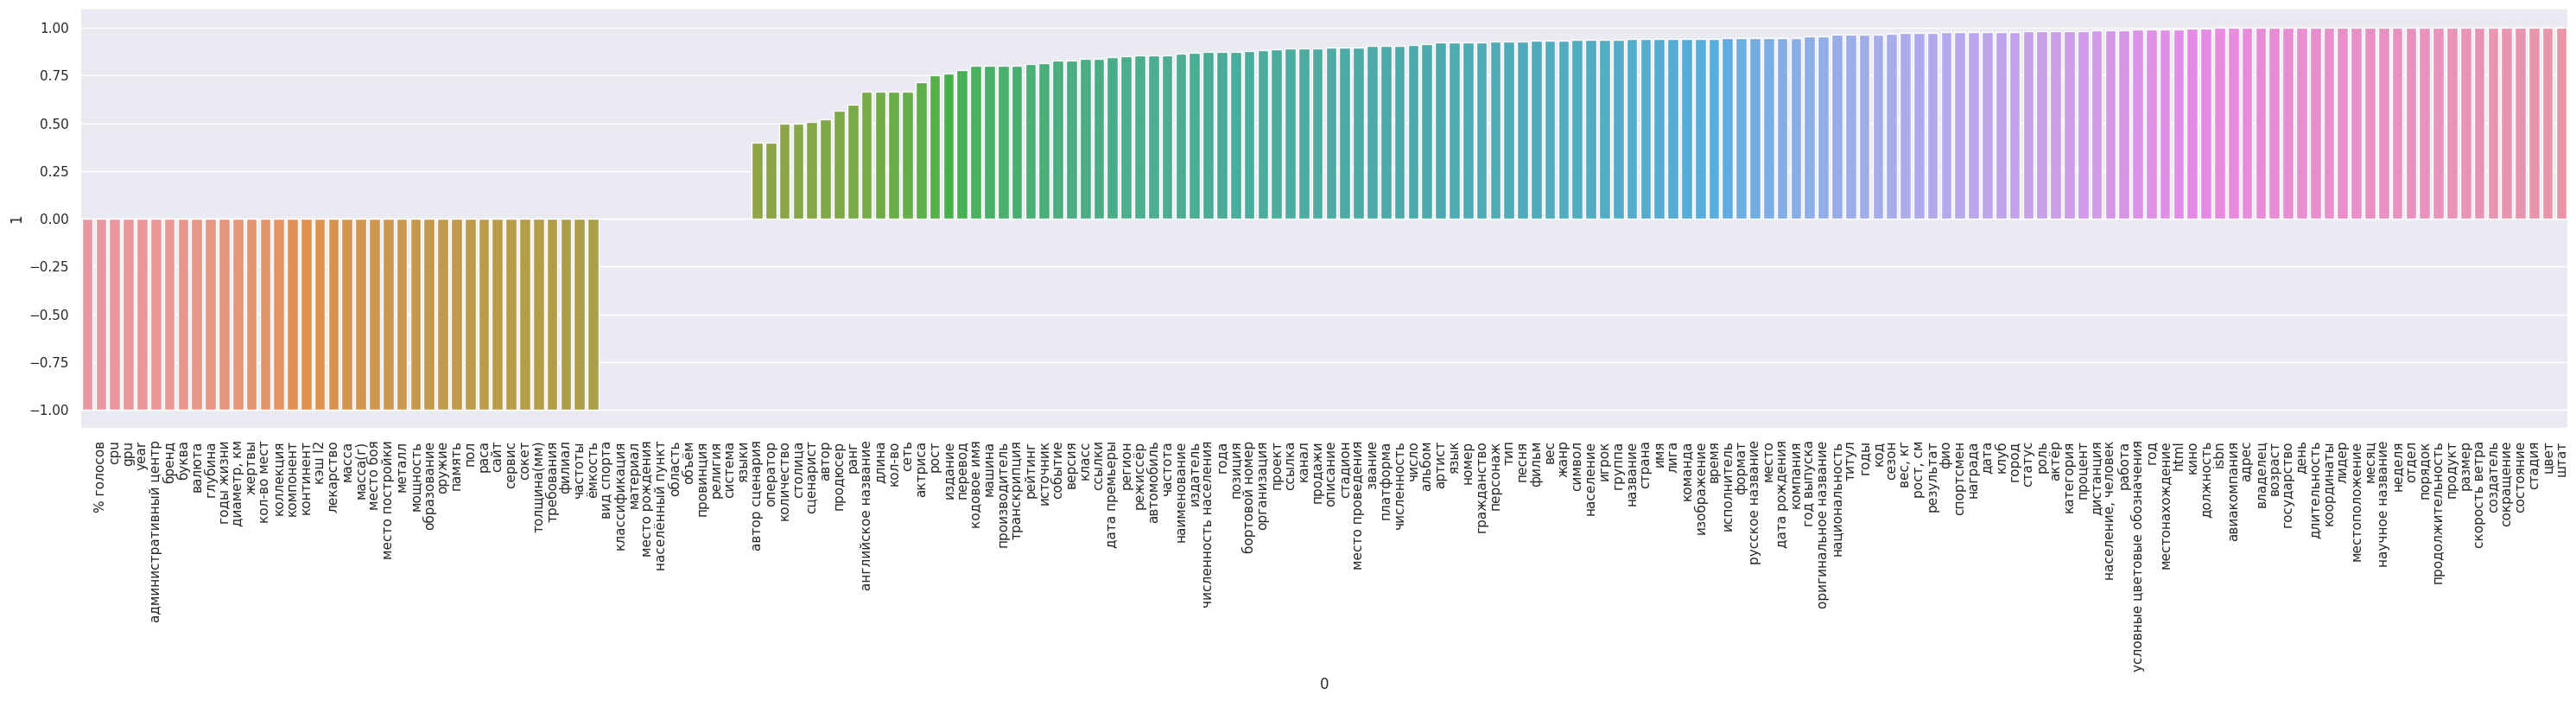

In [18]:
import seaborn

dff = pd.DataFrame(sorted([ (labels_encoder.inverse_transform([i])[0], f1_score_per_class[i]) for i in range(len(f1_score_per_class))], key=lambda x: x[1]))


seaborn.set(rc={'figure.figsize':(30,8.27)})
seaborn.barplot(dff, x=0, y=1)
# dff
plt.xticks(rotation=90)
plt.tight_layout()

In [14]:
from collections import Counter

def find_problematic_labels(model, data_loader):
    model.eval()

    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for batch in tqdm(data_loader):
            input_ids = batch["input_ids"].to(DEVICE)
            targets = batch["labels"]
            outputs = model(input_ids=input_ids)

            targets = targets.cpu()
            true_labels += list(targets[targets != -1])
            predicted_labels += nn.Softmax(dim=1)(outputs.cpu()).argmax(
                dim=1).tolist()


    c = Counter()
    for x, y in zip(list(true_labels), predicted_labels):
        if x.item() != y:
            c[( labels_encoder.inverse_transform([x.item()])[0],  labels_encoder.inverse_transform([y])[0])] += 1

    return c

counter = find_problematic_labels(model, val_dataloader)


  0%|          | 0/111 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [15]:
counter.most_common(30)


[(('количество', 'позиция'), 76),
 (('роль', 'актёр'), 53),
 (('актёр', 'роль'), 51),
 (('название', 'песня'), 20),
 (('название', 'альбом'), 18),
 (('время', 'результат'), 17),
 (('актёр', 'актриса'), 16),
 (('сценарист', 'режиссёр'), 16),
 (('спортсмен', 'имя'), 15),
 (('продюсер', 'сценарист'), 15),
 (('альбом', 'название'), 14),
 (('позиция', 'место'), 13),
 (('продюсер', 'режиссёр'), 13),
 (('фильм', 'название'), 12),
 (('песня', 'название'), 11),
 (('год', 'дата'), 11),
 (('место', 'город'), 11),
 (('гражданство', 'страна'), 11),
 (('регион', 'страна'), 10),
 (('дата рождения', 'дата'), 10),
 (('награда', 'категория'), 10),
 (('режиссёр', 'сценарист'), 10),
 (('место', 'позиция'), 10),
 (('название', 'фильм'), 9),
 (('позиция', 'номер'), 9),
 (('персонаж', 'роль'), 9),
 (('результат', 'время'), 8),
 (('команда', 'клуб'), 8),
 (('имя', 'спортсмен'), 8),
 (('режиссёр', 'исполнитель'), 7)]

In [16]:
train_counter = find_problematic_labels(model, train_dataloader)


  0%|          | 0/554 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [17]:
train_counter.most_common(30)


[(('сценарист', 'режиссёр'), 47),
 (('продюсер', 'режиссёр'), 43),
 (('продюсер', 'сценарист'), 37),
 (('бортовой номер', 'изображение'), 36),
 (('режиссёр', 'сценарист'), 31),
 (('место', 'номер'), 26),
 (('продюсер', 'актёр'), 15),
 (('режиссёр', 'актёр'), 13),
 (('ссылка', 'дата'), 9),
 (('сценарист', 'актёр'), 9),
 (('изображение', 'бортовой номер'), 8),
 (('страна', 'источник'), 8),
 (('актёр', 'режиссёр'), 8),
 (('номер', 'место'), 7),
 (('позиция', 'место'), 7),
 (('место', 'позиция'), 7),
 (('название', 'год'), 7),
 (('режиссёр', 'продюсер'), 7),
 (('рейтинг', 'место'), 6),
 (('награда', 'категория'), 6),
 (('ссылки', 'ссылка'), 6),
 (('результат', 'год'), 6),
 (('категория', 'год'), 6),
 (('актёр', 'продюсер'), 5),
 (('источник', 'ссылка'), 5),
 (('результат', 'номер'), 5),
 (('награда', 'организация'), 5),
 (('сценарист', 'продюсер'), 5),
 (('название', 'песня'), 5),
 (('ссылка', 'результат'), 4)]

In [218]:
#  print(val_paths[9616])

../filteredData2/4312554/table_12.csv


In [17]:
for num in range(0, len(val_paths)):

    df = pd.read_csv(val_paths[num], sep="|")

    tokens = []
    with open(val_paths[num]) as file:
        labels = file.readline().lower().rstrip('\n').split("|")

    if 'вид спорта' in labels:
        print(num)
        print(labels)
        # print(df.head())

        str_repr_of_column = df['Вид спорта'].astype(str).str.cat(sep=" ")[:200]
        print(str_repr_of_column)
        print(tokenizer.tokenize(str_repr_of_column, truncation=True, max_length=28))



# idx = 3567
# # 3567
# # 3872
# print(val_paths[idx])
# df = pd.read_csv(val_paths[idx], sep="|")

# print(df.head())




In [19]:
for num in range(0, len(val_paths)):

    df = pd.read_csv(val_paths[num], sep="|")

    tokens = []
    with open(val_paths[num]) as file:
        labels = file.readline().lower().rstrip('\n').split("|")

    if 'религия' in labels:
        print(num)
        print(labels)
        # print(df.head())

        str_repr_of_column = df['Религия'].astype(str).str.cat(sep=" ")[:200]
        print(str_repr_of_column)
        print(tokenizer.tokenize(str_repr_of_column, truncation=True, max_length=28))


# print(val_paths[20])
# df = pd.read_csv(val_paths[20], sep="|")
#
# print(df.head())




369
['религия', 'население', 'процент']
Все Индуизм Ислам Христианство Сикхизм Буддизм Джайнизм Другие Вне религии
['Все', 'Индуизм', 'Ислам', 'Христианство', 'Сикхизм', 'Буддизм', 'Джай', '##низ', '##м', 'Другие', 'Вне', 'религии']
